# Gradient Descent for Linear Regression(Optional Lab)

## Goals
In this lab we will automate the process of optimizing $w$ and $b$ using gradient descent.

In [1]:
import math
import copy
import numpy as np
import matplotlib.pyplot as plt
from lab_utils_uni import plt_house_x, plt_contour_wgrad, plt_divergence, plt_gradients


## Problem Statement

Let's use the same two data points as before - a house with 1000 square feet sold for $300,000 and a house with 2000 square feet sold for $500,000.

| Size (1000 sqft)     | Price (1000s of dollars) |
| ----------------| ------------------------ |
| 1               | 300                      |
| 2               | 500                      |


In [2]:
# Loading our data set
x_train = np.array([1.0, 2.0])#features
y_train = np.array([300.0, 500.0])#target value

### Computing Cost

In [3]:
# Function to calculate the cost
def compute_cost(x, y, w, b):

    m = x.shape[0]
    cost = 0

    for i in range(m):
        f_wb = w * x[i] + b
        cost = cost + (f_wb - y[i])**2
    total_cost = 1 / (2 * m) * cost

    return total_cost

## Gradient Descent Summary
We have developed a linear model that predicts $f_{w,b}(x^{(i)})$:
$$f_{w,b}(x^{(i)}) = wx^{(i)} + b \tag{1}$$
In linear regression, you utilize input training data to fit the parameters $w$,$b$ by minimizing a measure of the error between our predictions $f_{w,b}(x^{(i)})$ and the actual data $y^{(i)}$. The measure is called the $cost$, $J(w,b)$. In training you measure the cost over all of our training samples $x^{(i)},y^{(i)}$
$$J(w,b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})^2\tag{2}$$ 


In lecture, *gradient descent* was described as:

$$\begin{align*} \text{repeat}&\text{ until convergence:} \; \lbrace \newline
\;  w &= w -  \alpha \frac{\partial J(w,b)}{\partial w} \tag{3}  \; \newline 
 b &= b -  \alpha \frac{\partial J(w,b)}{\partial b}  \newline \rbrace
\end{align*}$$
where, parameters $w$, $b$ are updated simultaneously.  
The gradient is defined as:
$$
\begin{align}
\frac{\partial J(w,b)}{\partial w}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})x^{(i)} \tag{4}\\
  \frac{\partial J(w,b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)}) \tag{5}\\
\end{align}
$$

Here *simultaniously* means that you calculate the partial derivatives for all the parameters before updating any of the parameters.

## Implement Gradient Descent
You will implement gradient descent algorithm for one feature. You will need three functions. 
- `compute_gradient` implementing equation (4) and (5) above
- `compute_cost` implementing equation (2) above (code from previous lab)
- `gradient_descent`, utilizing compute_gradient and compute_cost

Conventions:
- The naming of python variables containing partial derivatives follows this pattern,$\frac{\partial J(w,b)}{\partial b}$  will be `dj_db`.
- w.r.t is With Respect To, as in partial derivative of $J(wb)$ With Respect To $b$.


### compute_gradient
`compute_gradient`  implements (4) and (5) above and returns $\frac{\partial J(w,b)}{\partial w}$,$\frac{\partial J(w,b)}{\partial b}$. The embedded comments describe the operations.

In [4]:
def compute_gradient(x, y, w, b):
    """
    Computes the gradient for linear regression 
    Args:
      x (ndarray (m,)): Data, m examples 
      y (ndarray (m,)): target values
      w,b (scalar)    : model parameters  
    Returns
      dj_dw (scalar): The gradient of the cost w.r.t. the parameters w
      dj_db (scalar): The gradient of the cost w.r.t. the parameter b     
     """

    # Number of training examples
    m = x.shape[0]
    dj_dw = 0
    dj_db = 0

    for i in range(m):
        f_wb = w * x[i] + b
        dj_dw_i = (f_wb - y[i]) * x[i]
        dj_db_i = f_wb - y[i]
        dj_db += dj_db_i
        dj_dw += dj_dw_i
    dj_dw = dj_dw / m
    dj_db = dj_db / m

    return dj_dw, dj_db

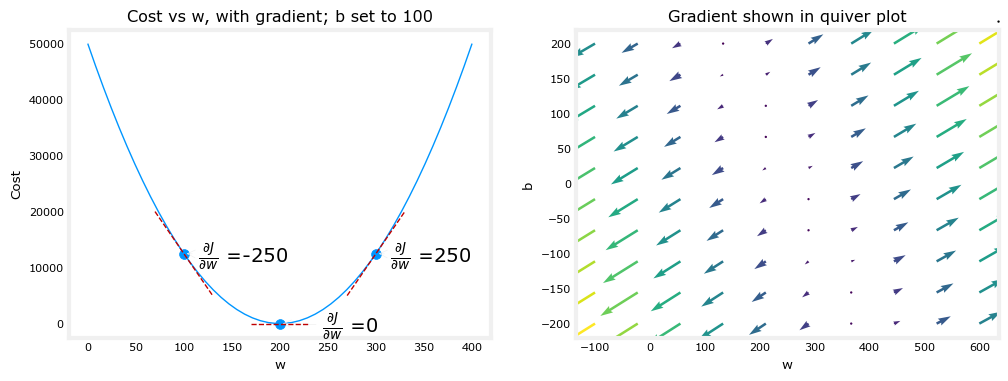

In [5]:
plt_gradients(x_train, y_train, compute_cost, compute_gradient)
plt.show()

Above, the left plot shows $\frac{\partial J(w,b)}{\partial w}$ or the slope of the cost curve relative to $w$ at three points. On the right side of the plot, the derivative is positive, while on the left it is negative. Due to the 'bowl shape', the derivatives will always lead gradient descent toward the bottom where the gradient is zero.
 
The left plot has fixed $b=100$. Gradient descent will utilize both $\frac{\partial J(w,b)}{\partial w}$ and $\frac{\partial J(w,b)}{\partial b}$ to update parameters. The 'quiver plot' on the right provides a means of viewing the gradient of both parameters. The arrow sizes reflect the magnitude of the gradient at that point. The direction and slope of the arrow reflects the ratio of $\frac{\partial J(w,b)}{\partial w}$ and $\frac{\partial J(w,b)}{\partial b}$ at that point.
Note that the gradient points *away* from the minimum. Review equation (3) above. The scaled gradient is *subtracted* from the current value of $w$ or $b$. This moves the parameter in a direction that will reduce cost.

###  Gradient Descent
Now that gradients can be computed,  gradient descent, described in equation (3) above can be implemented below in `gradient_descent`.

In [6]:
def gradient_descent(x, y, w_in, b_in, alpha, num_iters, cost_function, gradient_function):
    """
    Performs gradient descent to fit w,b. Updates w,b by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      x (ndarray (m,))  : Data, m examples 
      y (ndarray (m,))  : target values
      w_in,b_in (scalar): initial values of model parameters  
      alpha (float):     Learning rate
      num_iters (int):   number of iterations to run gradient descent
      cost_function:     function to call to produce cost
      gradient_function: function to call to produce gradient
      
    Returns:
      w (scalar): Updated value of parameter after running gradient descent
      b (scalar): Updated value of parameter after running gradient descent
      J_history (List): History of cost values
      p_history (list): History of parameters [w,b] 
      """

    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    p_history = []
    b = b_in
    w = w_in

    for i in range(num_iters):
        # Calculate the gradient and update the parameters using gradient_function
        dj_dw, dj_db = gradient_function(x, y, w, b)

        # Update Parameters using equation (3) above
        b = b - alpha * dj_db
        w = w - alpha * dj_dw

        # Save cost J at each iteration
        if i < 100000:      # prevent resource exhaustion
            J_history.append(cost_function(x, y, w, b))
            p_history.append([w, b])
        # Print cost every at intervals 10 times or as many iterations if < 10
        if i % math.ceil(num_iters/10) == 0:
            print(f"Iteration {i:4}: Cost {J_history[-1]:0.2e} ",
                  f"dj_dw: {dj_dw: 0.3e}, dj_db: {dj_db: 0.3e}  ",
                  f"w: {w: 0.3e}, b:{b: 0.5e}")

    return w, b, J_history, p_history  # return w and J,w history for graphing

In [7]:
# initialize parameters
w_init = 0
b_init = 0
# some gradient descent settings
iterations = 10000
tmp_alpha = 1.0e-2
# run gradient descent
w_final, b_final, J_hist, p_hist = gradient_descent(x_train, y_train, w_init, b_init, tmp_alpha,
                                                    iterations, compute_cost, compute_gradient)
print(f"(w,b) found by gradient descent: ({w_final:8.4f},{b_final:8.4f})")

Iteration    0: Cost 7.93e+04  dj_dw: -6.500e+02, dj_db: -4.000e+02   w:  6.500e+00, b: 4.00000e+00
Iteration 1000: Cost 3.41e+00  dj_dw: -3.712e-01, dj_db:  6.007e-01   w:  1.949e+02, b: 1.08228e+02
Iteration 2000: Cost 7.93e-01  dj_dw: -1.789e-01, dj_db:  2.895e-01   w:  1.975e+02, b: 1.03966e+02
Iteration 3000: Cost 1.84e-01  dj_dw: -8.625e-02, dj_db:  1.396e-01   w:  1.988e+02, b: 1.01912e+02
Iteration 4000: Cost 4.28e-02  dj_dw: -4.158e-02, dj_db:  6.727e-02   w:  1.994e+02, b: 1.00922e+02
Iteration 5000: Cost 9.95e-03  dj_dw: -2.004e-02, dj_db:  3.243e-02   w:  1.997e+02, b: 1.00444e+02
Iteration 6000: Cost 2.31e-03  dj_dw: -9.660e-03, dj_db:  1.563e-02   w:  1.999e+02, b: 1.00214e+02
Iteration 7000: Cost 5.37e-04  dj_dw: -4.657e-03, dj_db:  7.535e-03   w:  1.999e+02, b: 1.00103e+02
Iteration 8000: Cost 1.25e-04  dj_dw: -2.245e-03, dj_db:  3.632e-03   w:  2.000e+02, b: 1.00050e+02
Iteration 9000: Cost 2.90e-05  dj_dw: -1.082e-03, dj_db:  1.751e-03   w:  2.000e+02, b: 1.00024e+02


#### Summary
- The cost starts large and rapidly declines as described in the slide from the lecture.
- The partial derivatives, `dj_dw`, and `dj_db` also get smaller, rapidly at first and then more slowly. As shown in the diagram from the lecture, as the process nears the 'bottom of the bowl' progress is slower due to the smaller value of the derivative at that point.
- progress slows though the learning rate, alpha, remains fixed

### Cost versus iterations of gradient descent 
A plot of cost versus iterations is a useful measure of progress in gradient descent. Cost should always decrease in successful runs. The change in cost is so rapid initially, it is useful to plot the initial decent on a different scale than the final descent. In the plots below, note the scale of cost on the axes and the iteration step.

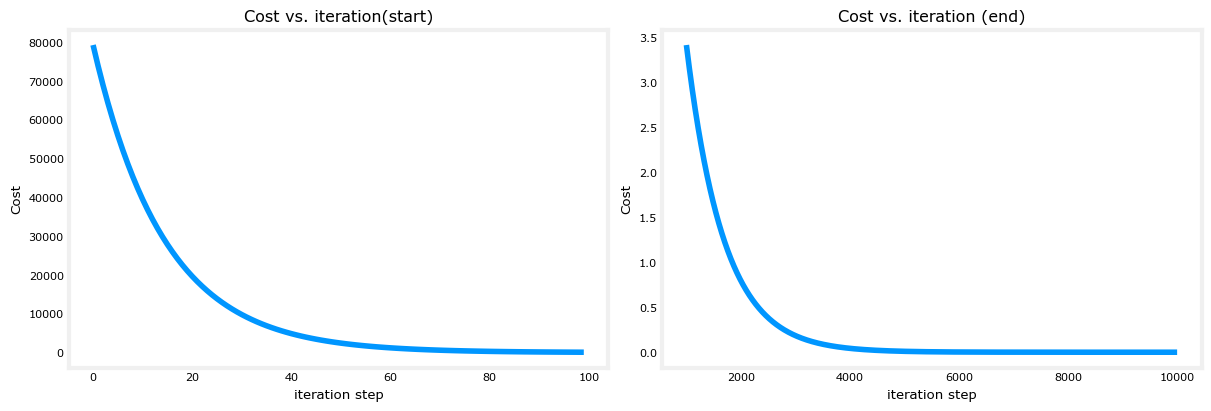

In [8]:
# plot cost versus iteration
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1.plot(J_hist[:100])
ax2.plot(1000 + np.arange(len(J_hist[1000:])), J_hist[1000:])
ax1.set_title("Cost vs. iteration(start)")
ax2.set_title("Cost vs. iteration (end)")
ax1.set_ylabel('Cost')
ax2.set_ylabel('Cost')
ax1.set_xlabel('iteration step')
ax2.set_xlabel('iteration step')
plt.show()